In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
import scipy.stats
import time


np.random.seed(6969)

In [2]:
def Franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeNoise(x, y, sigma=1):
    return Franke(x, y) + np.random.normal(0, sigma, np.shape(x))

In [3]:
nr_points_per_dim = 1001
nr_datapoints = nr_points_per_dim**2

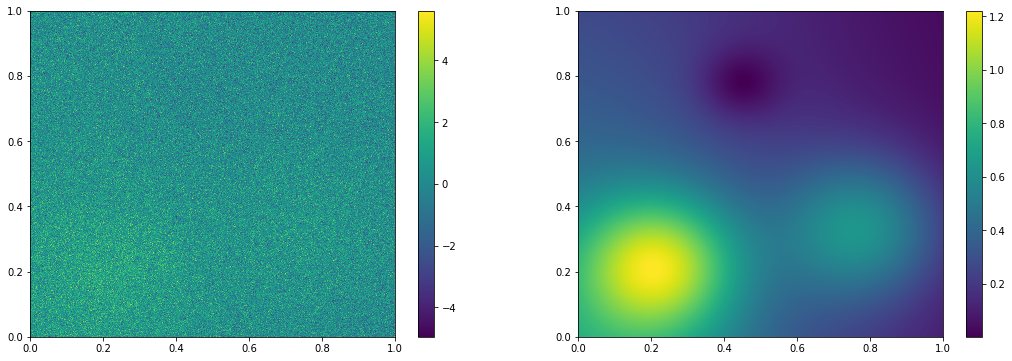

In [4]:
x = np.linspace(0, 1, nr_points_per_dim)
y = np.linspace(0, 1, nr_points_per_dim)
#x = np.random.uniform(0, 1, nr_points_per_dim)
#y = np.random.uniform(0, 1, nr_points_per_dim)
x_, y_ = np.meshgrid(x, y)

x_flat = x_.flatten()
y_flat = y_.flatten()

data = FrankeNoise(x_, y_)
f = data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt1 = ax1.pcolormesh(x_, y_, FrankeNoise(x_,y_));
fig.colorbar(plt1, ax=ax1);

plt2 = ax2.pcolormesh(x_, y_, Franke(x_, y_))
fig.colorbar(plt2, ax=ax2);

In [5]:
poly_order = 5

In [6]:
def make_X(x_flat, y_flat, poly_order):
    nr_terms = ((poly_order + 1)*(poly_order + 2))//2
    X = np.zeros((nr_datapoints, nr_terms))
    X[:,0] = 1

    i = 0
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                X[:,i] = x_flat**ix*y_flat**iy
    return X

In [7]:
def Model(beta, x, y, poly_order):
    i = 0
    result = beta[0]
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                result += beta[i]*x**ix*y**iy
    return result

In [8]:
X = make_X(x_flat, y_flat, poly_order)
beta = np.linalg.inv(X.T@X)@X.T@f
data_pred = Model(beta, x_, y_, poly_order)

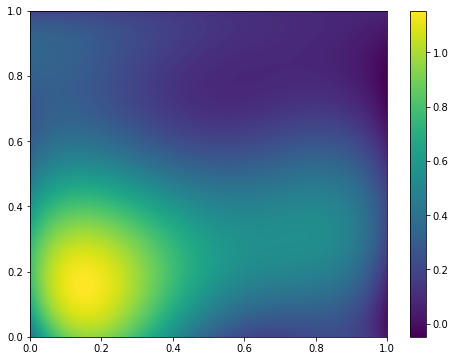

In [9]:
plt.figure(figsize=(8,6))
plt.pcolormesh(x_, y_, data_pred)
plt.colorbar();

In [10]:
MSE(data, data_pred), np.sqrt(MSE(data, data_pred))/np.mean(data), MSE(Franke(x_, y_), data_pred)

(1.0010105802534792, 2.4637773683150233, 0.0020279458754402114)

In [11]:
r2_score(data, data_pred)

0.05108589267415141

In [12]:
noise_pred = data - data_pred

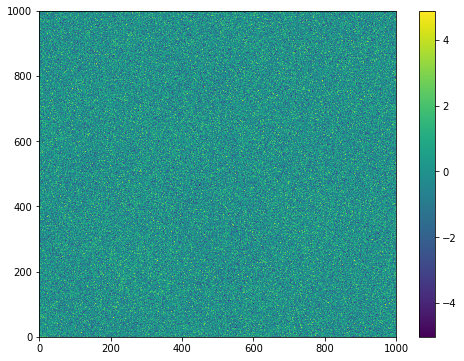

In [13]:
plt.figure(figsize = (8, 6))
plt.pcolormesh(noise_pred)
plt.colorbar();

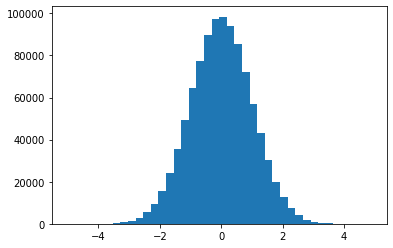

In [14]:
plt.hist(noise_pred.flatten(), bins=40);

0.9999988542328699

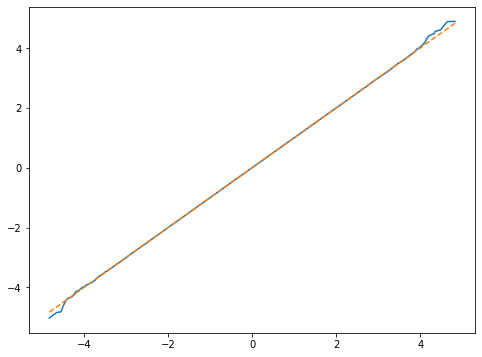

In [15]:
(x, y), (slope, intercept, r) = scipy.stats.probplot(noise_pred.flatten());

plt.figure(figsize = (8,6))
plt.plot(x,y);
plt.plot(x, intercept + x*slope, ls="--")
r

0.049448251724243164
0.11650228500366211
0.2879512310028076
0.6018764972686768
1.0424120426177979
1.4733412265777588
1.9001848697662354
2.441835880279541
3.0875306129455566
3.9558136463165283
4.872130393981934
6.00785231590271


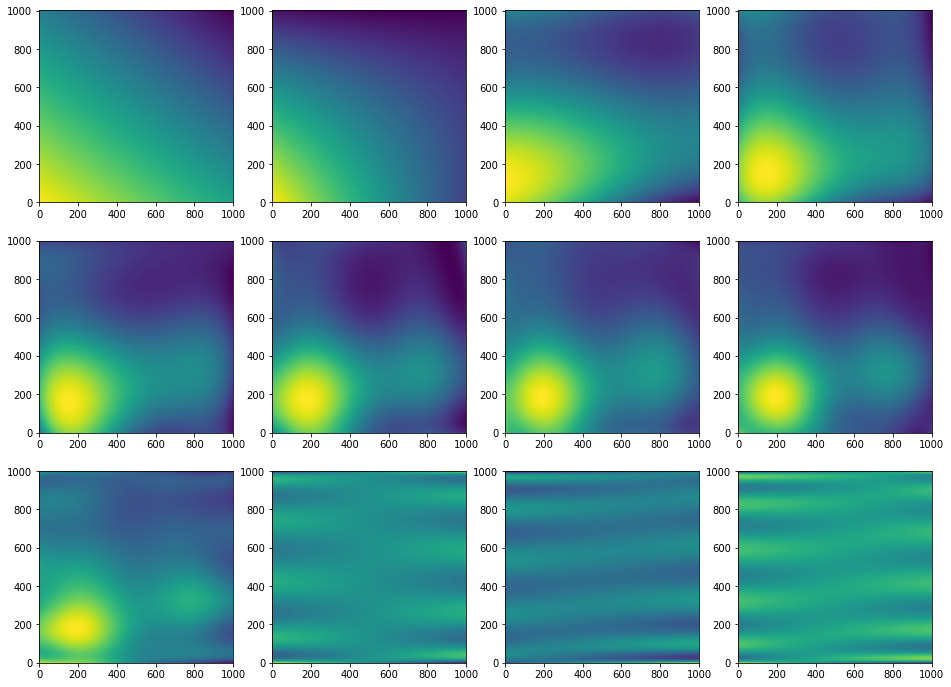

In [16]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 12
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X)@X.T@f
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

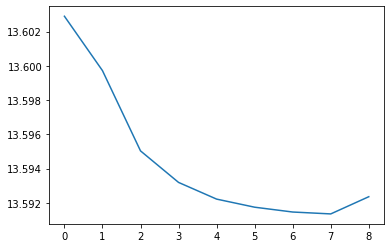

In [19]:
plt.plot(np.log(err_list[:9]));

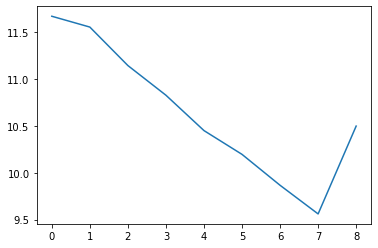

In [20]:
plt.plot(np.log(err_list_truemodel[:9]));